### PIPELINE OVERVIEW
+ graph with genes as nodes and edges
+ generate a matrix from nodes based on specific parameters (features, random walk, shortest path..)
+ multidimensional matrices > embedding with tsne into 2D or 3D 
----------
+ Visualization typologies:
+ 2D PORTRAIT
+ 3D PORTRAIT
+ 3D LANDSCAPE
+ 3D SPHERE
----------

In [1]:
from multidimvis_main import *

_____
# SELECT ONE NETWORK GRAPH
_____

In [2]:
################################################
#
# Y E A S T 
#
################################################

organism = 'Yeast'

data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

Counter(data['Interaction Detection Method'])
Counter(data['Interaction Types'])

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)

# ESSENTIAL GENES 
cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
essential_cere = cere_gene[(cere_gene['essentiality status'] == 'E')]
essential_genes_cere_list =  essential_cere['symbols'].tolist()

degree= dict(G_cere.degree())

mg = mygene.MyGeneInfo()
a = mg.querymany(essential_genes_cere_list, scopes='symbol', species=559292)
essential_genes_cere_names = pd.DataFrame.from_dict(a)
essential_genes_cere_entrez =  essential_genes_cere_names['entrezgene'].tolist()

cleaned_entrez_list = [x for x in essential_genes_cere_entrez if str(x) != 'nan']

degree_formatted={}
for k, v in degree.items():
    degree_formatted[k.replace("entrez gene/locuslink:","")] = v
    
index= []
essential = []
for i in cleaned_entrez_list:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            essential.append(val)  

no_essential_cere = cere_gene[(cere_gene['essentiality status'] == 'NE')]
no_essential_genes_cere_list =  no_essential_cere['symbols'].tolist()
b = mg.querymany(no_essential_genes_cere_list, scopes='symbol', species=559292)
no_essential_genes_cere_names = pd.DataFrame.from_dict(b)
no_essential_genes_cere_entrez =  no_essential_genes_cere_names['entrezgene'].tolist()
cleaned_entrez_list_no = [x for x in no_essential_genes_cere_entrez if str(x) != 'nan']

index= []
no_essential = []
for i in cleaned_entrez_list_no:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            no_essential.append(val)
            
#df_cere = pd.DataFrame({'essential': pd.Series(essential), 'no_essential': pd.Series(no_essential)})


no_ess_id = no_essential_genes_cere_names['entrezgene']
ess_id = essential_genes_cere_names['entrezgene']

G = G_cere

#edge_list = nx.write_edgelist(G, "Yeast_edgelist_directinteractiononly.txt")

querying 1-1000...done.
querying 1001-1037...done.
Finished.
15 input query terms found no hit:
	['nan', 'YGR251W', 'YHR122W', 'TID3', 'YJR141W', 'YLR099W-A', 'MDN1', 'YLR132C', 'YLR243W', 'YMR134W
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4543...done.
Finished.
1 input query terms found dup hits:
	[('IMP2', 2)]
311 input query terms found no hit:
	['FLP1', 'REP1', 'RAF1', 'REP2', 'YAL018C', 'YAL044W-A', 'AIM1', 'YAL064C-A', 'YBL010C', 'YBL059W', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [5]:
################################################
#
# H U M A N 
#
################################################

organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}

### GENE ID to SYN (e.g. HOVERINFO for nodes)

In [6]:
#entrez_syn = pd.read_csv('input/entrezid_syn.csv', index_col=0)
#d_entrez_syn = dict(zip(entrez_syn.index,entrez_syn['db_synonym']))

d_entrez_syn,d_syn_entrez = genent2sym()

d_gene2syn = {}
for k,v in d_entrez_syn.items():
    try:
        if k in G.nodes():
            d_gene2syn[k] = v
    except: 
           d_gene2syn['None'] = 'no entry'
            
d_genes_withsyn = {}
for g in G.nodes():
    for k,v in d_gene2syn.items():
        if g == k:
            d_genes_withsyn[g] = v
            
d_genes_nosyn = {}
for gene in G.nodes():
    if gene not in d_genes_withsyn.keys():
        d_genes_nosyn[gene] = 'no entry'
        
d_genes_all = {**d_genes_withsyn, **d_genes_nosyn}
d_genes_syn_sorted = {key:d_genes_all[key] for key in G.nodes()}

l_genes_syn=[]
for k,v in d_genes_syn_sorted.items():
    try:
        l_genes_syn.append(set(v.split('|')))
    except:
        l_genes_syn.append(v)
        
d_genes_syn_complete = {}
for i,v in enumerate(d_genes_syn_sorted.keys()):
    for idx,l in enumerate(l_genes_syn):
        if i==idx:
            d_genes_syn_complete[v] = l
            
l_features = list(d_genes_syn_complete.values())

In [116]:
l_features[:10] 

[{'TRAK2'},
 {'OGT'},
 {'GABRB2'},
 {'KCNJ2'},
 {'TRAK1'},
 {'NUP98'},
 {'ELAVL1'},
 {'OFD1'},
 {'FAM83D'},
 {'HOOK1'}]

In [7]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s'%len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 16376
Number of edges: 309355
Network density: 0.2%


_____
# SELECT ONF OF THE FOLLOWING DISTANCE MATRICES
_____

### + STRUCTURAL : Graph based

#### Adjacency 

In [114]:
%%time

A = nx.adjacency_matrix(G)
DM_adj = A.toarray()

CPU times: user 1.15 s, sys: 222 ms, total: 1.37 s
Wall time: 1.41 s


#### Shortest path lengths 

In [178]:
%%time

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1

Mspl = np.zeros(len(list(G.nodes())))

for n1 in range(len(list(G.nodes()))):
    vec = []
    for n2 in range(len(list(G.nodes()))):
        geneA = d_idx_entz[n1]
        geneB = d_idx_entz[n2]
        try:
            spl = nx.shortest_path_length(G,geneA,geneB)
            vec.append(spl)
        except nx.NetworkXNoPath:
            print('no path')
        
    Mspl = np.vstack((Mspl,vec))
Mspl = np.delete(Mspl, (0), axis=0)

DM_spl = Mspl 

CPU times: user 6min 30s, sys: 3.68 s, total: 6min 34s
Wall time: 6min 38s


#### Random Walk with restart probability

In [5]:
%%time

# Restart probability
r = .8 # originally 0.8
alpha = 1.0 # indicating "randomness" 

DM_m = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))

DM_m_df = pd.DataFrame(DM_m)
# DM_m_df.sum(axis=0)

DM_m_transposed = DM_m_df.T
DM_m_transposed.index = list(G.nodes())

metric = "cosine" 
DM_m_new = pd.DataFrame(distance.squareform(distance.pdist(DM_m_transposed, metric)))

DM_m = DM_m_new
DM_m.index = list(G.nodes())
DM_m.columns = list(G.nodes())

CPU times: user 54min 28s, sys: 40 s, total: 55min 8s
Wall time: 50min 38s


#### IMPORT PRECALCULATED 

In [8]:
DM_adj = pd.read_csv('output_csv/Adjacency_Dataframe_'+organism+'.csv', index_col=0)
DM_spl = pd.read_csv('output_csv/SPL_Dataframe_'+organism+'.csv', index_col=0)
DM_m = pd.read_csv('output_csv/RWR_Dataframe_'+organism+'.csv', index_col=0)

DM_adj_r = DM_adj.round(2)
DM_spl_r = DM_spl.round(2)
DM_m_r = DM_m.round(2)

In [9]:
DM_adj = DM_adj_r
DM_spl = DM_spl_r
DM_m = DM_m_r

### + STRUCTURAL : Centrality measures

In [ ]:
%%time 

# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)

# CLOSENESS CENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)
    
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)

# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)
    
    
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
df_centralities = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                      ]) 


#l_features = [] 
#for i in feature_dict_sorted.items():
#    k = list(i)
#    l_features.append(k)
    
# feature_df.to_csv(r'output_csv/Features_centralities_Dataframe_'+organism+'.csv', index = True)

DM_centralities = pd.DataFrame(distance.squareform(distance.pdist(df_centralities, 'cosine')))

DM_centralities.index = list(G.nodes())
DM_centralities.columns = list(G.nodes())

#### IMPORT PRECALCULATED 

In [6]:
df_centralities = pd.read_csv('output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(),df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))
l_features = []
for i in d_centralities.items():
    k=list(i)
    l_features.append(k)

DM_centralities = pd.DataFrame(distance.squareform(distance.pdist(df_centralities, 'cosine')))

DM_centralities.index = G.nodes()
DM_centralities.columns = G.nodes()

### + FUNCTIONAL : Molecular Function

#### IMPORT PRECALCULATED 

In [ ]:
DM_MF = pd.read_csv('output_csv/DistanceMatrix_goMF_Dataframe_Human.csv', index_col=0)

DM_MF_mod = DM_MF.round(decimals=4)

In [465]:
DM_MF = DM_MF_mod  

In [466]:
DM_MF

2       9      10      12      13      14      15      16  \
2          0.0000  3.4641  3.3166  3.1623  4.0000  3.6056  3.3166  4.1231   
9          3.4641  0.0000  1.0000  2.0000  2.4495  1.7321  1.7321  2.6458   
10         3.3166  1.0000  0.0000  1.7321  2.6458  2.0000  1.4142  2.8284   
12         3.1623  2.0000  1.7321  0.0000  2.8284  2.2361  1.7321  3.0000   
13         4.0000  2.4495  2.6458  2.8284  0.0000  2.6458  2.6458  3.3166   
...           ...     ...     ...     ...     ...     ...     ...     ...   
107987462  3.6056  2.2361  2.0000  2.2361  3.0000  2.4495  2.0000  3.1623   
107987491  3.6056  2.2361  2.0000  2.2361  3.0000  2.4495  2.0000  3.1623   
109703458  3.4641  1.4142  1.7321  2.0000  2.4495  1.7321  1.7321  2.6458   
110117499  3.4641  1.4142  1.7321  2.0000  2.4495  1.7321  1.7321  2.6458   
110599564  3.6056  1.7321  2.0000  2.2361  2.6458  2.0000  2.0000  2.8284   

               18      19  ...  102724159  102724334  102724428  102724862  \
2          3.8730  5.0000  ...     3.4641     3.4641     3.4641     3.3166   
9          2.2361  4.3589  ...     1.4142     1.4142     1.4142     1.7321   
10         2.4495  4.2426  ...     1.7321     1.7321     1.7321     2.0000   
12         2.6458  4.3589  ...     2.0000     1.4142     2.0000     2.2361   
13         3.0000  4.7958  ...     2.4495     2.4495     2.4495     2.6458   
...           ...     ...  ...        ...        ...        ...        ...   
107987462  2.8284  4.4721  ...     2.2361     2.2361     2.2361     2.4495   
107987491  2.8284  4.4721  ...     2.2361     2.2361     2.2361     2.4495   
109703458  2.2361  4.3589  ...     1.4142     1.4142     1.4142     1.7321   
110117499  2.2361  4.3589  ...     1.4142     1.4142     1.4142     1.7321   
110599564  2.4495  4.4721  ...     1.7321     1.7321     1.7321     2.0000   

           105371242  107987462  107987491  109703458  110117499  110599564  
2             3.7417     3.6056     3.6056     3.4641     3.4641     3.6056  
9             2.0000     2.2361     2.2361     1.4142     1.4142     1.7321  
10            2.2361     2.0000     2.0000     1.7321     1.7321     2.0000  
12            2.4495     2.2361     2.2361     2.0000     2.0000     2.2361  
13            2.8284     3.0000     3.0000     2.4495     2.4495     2.6458  
...              ...        ...        ...        ...        ...        ...  
107987462     2.6458     0.0000     2.4495     2.2361     2.2361     2.4495  
107987491     2.6458     2.4495     0.0000     2.2361     2.2361     2.4495  
109703458     2.0000     2.2361     2.2361     0.0000     1.4142     1.7321  
110117499     2.0000     2.2361     2.2361     1.4142     0.0000     1.7321  
110599564     2.2361     2.4495     2.4495     1.7321     1.7321     0.0000  

[15165 rows x 15165 columns]

### + FUNCTIONAL : Cellular Components

#### IMPORT PRECALCULATED 

In [14]:
DM_CC = pd.read_csv('output_csv/DistanceMatrix_goCC_Dataframe_Human.csv', index_col=0)

DM_CC_mod = DM_CC.round(decimals=4)

In [15]:
DM_CC = DM_CC_mod

In [21]:
DM_CC

1       2       9      10      12      13      14      15  \
1          0.0000  2.2361  3.0000  3.0000  2.2361  3.0000  3.4641  3.3166   
2          2.2361  0.0000  2.0000  2.0000  2.4495  2.4495  2.6458  2.4495   
9          3.0000  2.0000  0.0000  0.0000  3.1623  1.4142  1.7321  1.4142   
10         3.0000  2.0000  0.0000  0.0000  3.1623  1.4142  1.7321  1.4142   
12         2.2361  2.4495  3.1623  3.1623  0.0000  3.1623  3.6056  3.4641   
...           ...     ...     ...     ...     ...     ...     ...     ...   
107984208  2.6458  2.4495  1.4142  1.4142  2.8284  1.4142  2.2361  2.0000   
107987462  3.3166  2.8284  2.0000  2.0000  3.4641  2.0000  2.6458  2.4495   
107987491  3.7417  3.0000  2.2361  2.2361  3.6056  2.6458  2.8284  2.6458   
109703458  3.3166  2.8284  2.0000  2.0000  3.4641  2.0000  2.6458  2.4495   
110117499  3.0000  2.4495  1.4142  1.4142  3.1623  1.4142  2.2361  2.0000   

               16      18  ...  102724159  102724334  102724428  105371242  \
1          3.3166  3.3166  ...     3.1623     3.1623     3.3166     3.0000   
2          2.4495  2.8284  ...     2.6458     2.6458     2.8284     2.4495   
9          2.0000  2.0000  ...     1.7321     1.7321     2.0000     1.4142   
10         2.0000  2.0000  ...     1.7321     1.7321     2.0000     1.4142   
12         3.4641  3.4641  ...     3.3166     3.0000     3.1623     3.1623   
...           ...     ...  ...        ...        ...        ...        ...   
107984208  2.4495  2.0000  ...     1.7321     1.7321     2.0000     1.4142   
107987462  2.8284  2.4495  ...     2.2361     2.6458     2.4495     2.0000   
107987491  3.0000  3.0000  ...     2.8284     2.0000     2.6458     2.6458   
109703458  2.4495  1.4142  ...     2.2361     2.6458     2.4495     1.4142   
110117499  2.4495  2.0000  ...     1.7321     2.2361     2.0000     1.4142   

           107983988  107984208  107987462  107987491  109703458  110117499  
1             3.0000     2.6458     3.3166     3.7417     3.3166     3.0000  
2             2.4495     2.4495     2.8284     3.0000     2.8284     2.4495  
9             1.4142     1.4142     2.0000     2.2361     2.0000     1.4142  
10            1.4142     1.4142     2.0000     2.2361     2.0000     1.4142  
12            3.1623     2.8284     3.4641     3.6056     3.4641     3.1623  
...              ...        ...        ...        ...        ...        ...  
107984208     1.4142     0.0000     2.0000     2.6458     2.0000     1.4142  
107987462     2.0000     2.0000     0.0000     3.0000     2.4495     2.0000  
107987491     2.6458     2.6458     3.0000     0.0000     2.6458     2.6458  
109703458     2.0000     2.0000     2.4495     2.6458     0.0000     2.0000  
110117499     1.4142     1.4142     2.0000     2.6458     2.0000     0.0000  

[15418 rows x 15418 columns]

### + FUNCTIONAL : Biological Processes

#### IMPORT PRECALCULATED 

In [18]:
DM_BP = pd.read_csv('output_csv/DistanceMatrix_goBP_Dataframe_Human.csv', index_col=0)
    
DM_BP_mod = DM_BP.round(decimals=4)

In [19]:
DM_BP = DM_BP_mod

In [ ]:
DM_BP

### + FUNCTIONAL : Disease Annotation

#### IMPORT PRECALCULATED 

In [691]:
DM_Disease = pd.read_csv('output_csv/DistanceMatrix_Disease_Dataframe_Human.csv', index_col=0)
    
DM_Disease_mod = DM_Disease.round(decimals=4)

In [692]:
DM_Disease = DM_Disease_mod

In [693]:
DM_Disease

389289     4524     4353    27127     5925    10735    26259  \
389289   0.0000  14.7309   9.3808   0.0000  10.9087   3.6056   0.0000   
4524    14.7309   0.0000  13.1529  14.7309  15.8114  14.6969  14.7309   
4353     9.3808  13.1529   0.0000   9.3808  12.8452  10.0499   9.3808   
27127    0.0000  14.7309   9.3808   0.0000  10.9087   3.6056   0.0000   
5925    10.9087  15.8114  12.8452  10.9087   0.0000  10.7703  10.9087   
...         ...      ...      ...      ...      ...      ...      ...   
63910    3.1623  14.7986   9.4868   3.1623  11.0000   4.7958   3.1623   
7287     8.7178  15.9060  12.1655   8.7178  13.0767   9.4340   8.7178   
11173    3.4641  14.7309   9.5917   3.4641  11.1803   5.0000   3.4641   
9962     3.3166  14.8997   9.6437   3.3166  11.3137   4.8990   3.3166   
5973     6.9282  16.0935  11.4018   6.9282  12.7671   7.8102   6.9282   

           1029     9649     1630  ...    65125     6787    90678    10661  \
389289  12.4900   0.0000   6.2450  ...   5.2915   3.0000   8.6023   4.3589   
4524    16.9411  14.7309  15.1658  ...  14.7986  14.7648  16.8819  15.0333   
4353    14.2829   9.3808  10.8167  ...   9.6954   9.5394  12.5698  10.1489   
27127   12.4900   0.0000   6.2450  ...   5.2915   3.0000   8.6023   4.3589   
5925    12.9228  10.9087  11.8322  ...  11.7898  11.2250  13.7477  11.5758   
...         ...      ...      ...  ...      ...      ...      ...      ...   
63910   12.6491   3.1623   7.0000  ...   5.0990   3.0000   8.4853   4.1231   
7287    14.6287   8.7178  10.6301  ...   9.2736   8.5440  11.4891   9.1104   
11173   12.8841   3.4641   7.1414  ...   4.6904   3.3166   8.6023   4.3589   
9962    12.7671   3.3166   7.0711  ...   5.1962   3.1623   8.5440   4.2426   
5973    14.2127   6.9282   9.3274  ...   7.8740   6.8557  10.4881   7.4162   

          56479    63910     7287    11173     9962     5973  
389289   3.4641   3.1623   8.7178   3.4641   3.3166   6.9282  
4524    14.7986  14.7986  15.9060  14.7309  14.8997  16.0935  
4353     9.7980   9.4868  12.1655   9.5917   9.6437  11.4018  
27127    3.4641   3.1623   8.7178   3.4641   3.3166   6.9282  
5925    11.0000  11.0000  13.0767  11.1803  11.3137  12.7671  
...         ...      ...      ...      ...      ...      ...  
63910    3.1623   0.0000   8.6023   3.1623   3.0000   6.7823  
7287     8.0000   8.6023   0.0000   8.6023   8.6603  10.5830  
11173    3.4641   3.1623   8.6023   0.0000   3.3166   6.7823  
9962     3.3166   3.0000   8.6603   3.3166   0.0000   6.8557  
5973     6.9282   6.7823  10.5830   6.7823   6.8557   0.0000  

[6538 rows x 6538 columns]

_____

### SELECT ONE DISTANCE MATRIX

In [136]:
feature = 'adj'
DM = DM_adj

#feature = 'spl'
#DM = DM_spl.fillna(DM.max()[0]**2) 

#feature = 'rwr'
#DM = DM_m

#feature = 'centralities'
#DM = DM_centralities

#feature = 'bioproc'
# DM = DM_BP

#feature = 'molfunc'
#DM = DM_MF

# feature = 'cellcomp'
# DM = DM_CC

#feature = 'disease'
#DM = DM_Disease


# set gene list (= G.nodes())
genes = []
for i in DM.index:
    genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

In [137]:
len(G.nodes())

5785

In [138]:
len(genes)

5785

In [139]:
len(genes_rest)

0

# BIOLOGICAL NODE PROPERTIES 

## ESSENTIALITY

In [155]:
# Essentiality Score
essentials = []
for i in ess_id:
    essentials.append('entrez gene/locuslink:'+str(i))
    
nonessentials = []
for i in no_ess_id:
    nonessentials.append('entrez gene/locuslink:'+str(i))
    
major_score = 1
minor_score = -1

d_essentiality_scores = node_essentiality_scores(G, essentials, nonessentials, major_score, minor_score)
d_essentiality_scores_sorted = {key:d_essentiality_scores[key] for key in G.nodes()}

In [ ]:
# add statistical test for checking for essentiality to degree - correlation

## CANCER DRIVERS 

## RARE DISEASE GENES

____________
# VISUAL PRE-SETTINGS
____________

In [156]:
edge_width = 0.1
edge_color = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 0.5

opacity_nodes = 0.9
node_edge_col = 'k'

### NODE SIZE

In [157]:
scalef= 0.25
size = list(draw_node_degree(G, scalef).values())

scalef= 0.1
size3d = list(draw_node_degree_3D(G, scalef).values())

### COLOUR PARAMETERS

+ COLOR SPECIFIC GENES (LIST)

In [195]:
def color_edges_from_genelist(G, l_genes, color):
    edge_lst = [(u,v) for u,v in G.edges(l_genes) if u in l_genes and v in l_genes]

    d_col_edges = {}
    for e in edge_lst:
        d_col_edges[e]=color
        
    d_nocol_edges = {}
    for e in G.edges():
        if e not in l_genes:
            d_nocol_edges[e]='lightgrey'
            
    d_both = {**d_col_edges, **d_nocol_edges}

    return d_both

In [208]:
# ----------------------------------------------------        
# Essential genes 
# ----------------------------------------------------  
     
color_method = 'Essentiality' 
color = 'orange'

l_genes = essentials

# n o d e s 
colours = color_nodes_from_genelist(G, l_genes, color)

# e d g e s 
d_edge_color_unsort = color_edges_from_genelist(G, l_genes, color)
d_edge_color_sorted =  {key:d_edge_color_unsort[key] for key in G.edges()}
edge_col = list(d_edge_color_sorted.values())

In [254]:
d_edge_color_unsort = color_edges_from_genelist(G, l_genes, color)

In [ ]:
# fix edge coloring 

In [ ]:
for i in d_edge_color_sorted.values():
    if i != 'lightgrey':
        print(i)

In [ ]:
# ----------------------------------------------------        
# Cancer Driver Genes
# ----------------------------------------------------  
     
color_method = 'Cancer Drivers' 
color = 'blue'

# n o d e s 
l_genes = l_cancerdrivers # my list of gene identifiers
colours = color_nodes_from_genelist(G, l_genes, color)

# e d g e s 
edge_color = list(color_edges_from_genelist(G, l_genes, color).values())

In [ ]:
# ----------------------------------------------------        
# Rare disease genes 
# ----------------------------------------------------  
     
color_method = 'Rare Disease Genes' 
color = 'red'

# l_genes = 

# n o d e s 
# colours = color_nodes_from_genelist(G, l_genes, 'red')

# e d g e s 
# edge_color = color_edges_from_genelist(G, l_genes, color)

+ COLOR > GRADIENT : BY DICT INPUT (e.g. different values for nodes, like Closeness Centrality) 

In [29]:
# ----------------------------------------------------        
# Define colour parameter with dict (gradient)
# ----------------------------------------------------        
color_method = 'clos'
d_to_be_coloured = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)


# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
pal = sns.color_palette('Reds', colour_count)
palette = pal.as_hex()

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col_clos = list(d_node_colour_sorted.values())

colours_hex = l_col_clos 


d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(pal):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col = list(d_node_colour_sorted.values())

colours = l_col

## ANNOTATIONS 

In [ ]:
# ----------------------------------------------------        
# annotations 
# ----------------------------------------------------        

# Choose Specific Gene to annotate 
geneid = '4790'
genesyn = d_geneid_IBDsyn['4790'] 

x_gene = posG[geneid][0]
y_gene = posG[geneid][1]
z_gene = posG[geneid][2]

annotations = [dict ( 
                x=x_gene,
                y=y_gene,            
                z=z_gene, 
                showarrow=True,
                text = 'IBD GENE: '+genesyn,
                ay = -100,
                ax = -100,
                opacity = 0.8,
                arrowhead = 0,
                arrowwidth = 0.5 ,
                arrowcolor = "white" 
            )]

annotations = [dict(
                x=max(posG.values())[0],
                y=max(posG.values())[1],
                showarrow=True,
                text=disease_category,
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                )]

annotations3d = [dict(
                x=max(posG.values())[0],
                y=max(posG.values())[1],
                z=max(posG.values())[2],
                showarrow=True,
                text=disease_category,
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                )]

____________
# 2D 
____________

___
## PORTRAITS
___

### tSNE EMBEDDING 2D

In [145]:
prplxty = 40 # range: 5-50 / default = 30
density = 1  # default 12.
l_rate = 200 # default 200.
steps = 800 # min 250

metric = 'cosine'

In [146]:
%%time 
tsne = embed_tsne_2D(DM, prplxty, density, l_rate, steps, metric)

CPU times: user 2min 55s, sys: 4.63 s, total: 2min 59s
Wall time: 25.6 s


In [147]:
# MAIN (if not all G.nodes)
posG_tsne = get_posG_2D(genes, tsne)

# REST (if main = G.nodes then rest will be ignored / empty)
# generate circle coordinates for rest genes (without e.g. GO term or Disease Annotation)
t = np.random.uniform(0,2*np.pi,len(genes_rest))
r = np.random.uniform(80,100, len(genes_rest)) #inner + outer radius

x = r*np.cos(t)*10 
y = r*np.sin(t)*2

rest = []
for i,j in zip(x,y):
        rest.append((i,j))
        
posG_rest = dict(zip(genes_rest, rest))

posG_all = {**posG_tsne, **posG_rest}
posG = {key:posG_all[key] for key in G.nodes()}

### 2D tSNE PORTRAITS

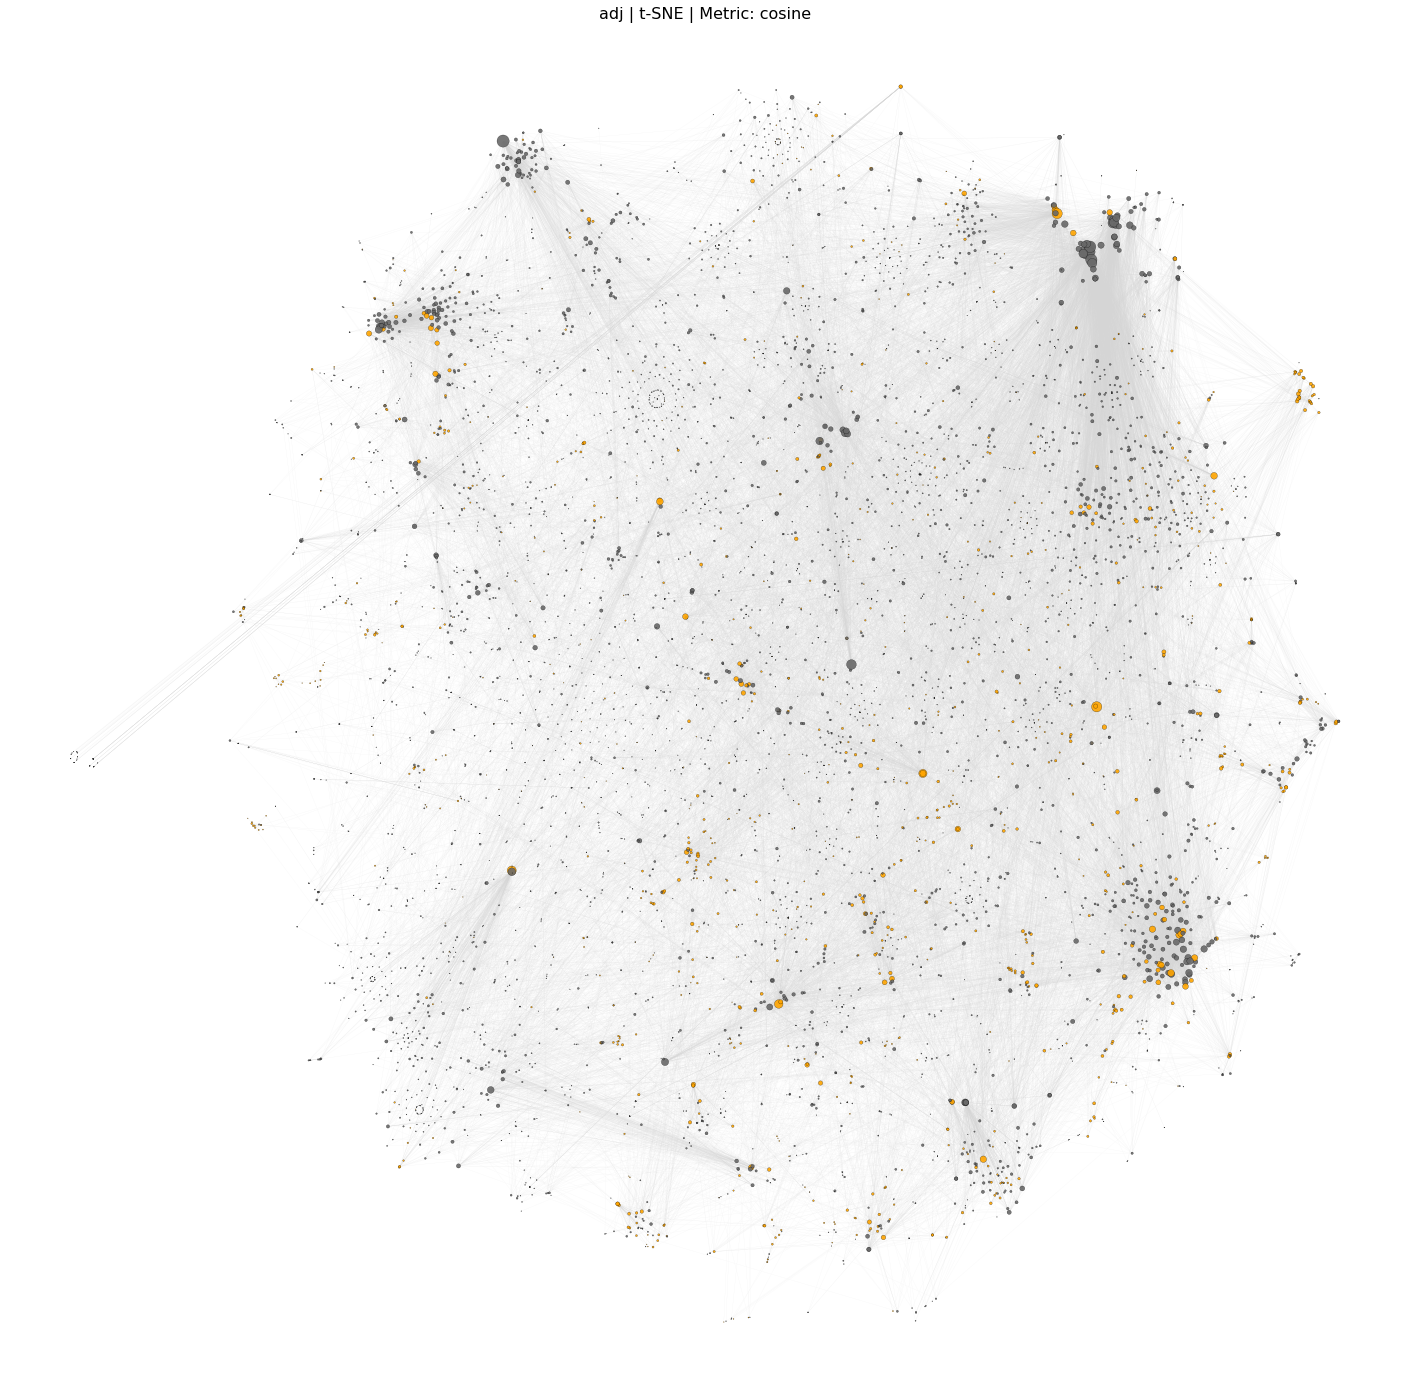

In [205]:
plt.figure(figsize=(25,25))
plt.title(feature+' | t-SNE | Metric: '+metric, size= 16)

nx.draw_networkx_nodes(G, posG, edgecolors = node_edge_col, linewidths = 0.25, node_color = colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG, width = edge_width, edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtsne_'+feature+'_'+metric+'_'+str(prplxty)+'_'+str(density)+'_'+str(l_rate)+'_'+str(steps)
        +'_'+organism+'_'+color_method+'_nx.png')

plt.show()

### UMAP EMBEDDING 2D 
+https://umap-learn.readthedocs.io/en/latest/embedding_space.html

In [132]:
n_neighbors = 5 # balance between local and global structure in the data
spread = 1.
min_dist = 0.5 # defines how dense points are stacked together 
metric ='cosine'

In [133]:
%%time 
umap = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 25.7 s, sys: 984 ms, total: 26.6 s
Wall time: 15.5 s


In [134]:
# MAIN (if not all G.nodes)
posG_umap = get_posG_2D(genes, umap)

# REST (if main = G.nodes then rest will be ignored / empty)
# generate circle coordinates for rest genes (without e.g. GO term or Disease Annotation)
t = np.random.uniform(0,2*np.pi,len(genes_rest))
r = np.random.uniform(80,100, len(genes_rest)) #inner + outer radius

x = r*np.cos(t)*10 
y = r*np.sin(t)*2

rest = []
for i,j in zip(x,y):
        rest.append((i,j))
        
posG_rest = dict(zip(genes_rest, rest))

posG_all = {**posG_umap, **posG_rest}
posG = {key:posG_all[key] for key in G.nodes()}

### 2D UMAP PORTRAITS

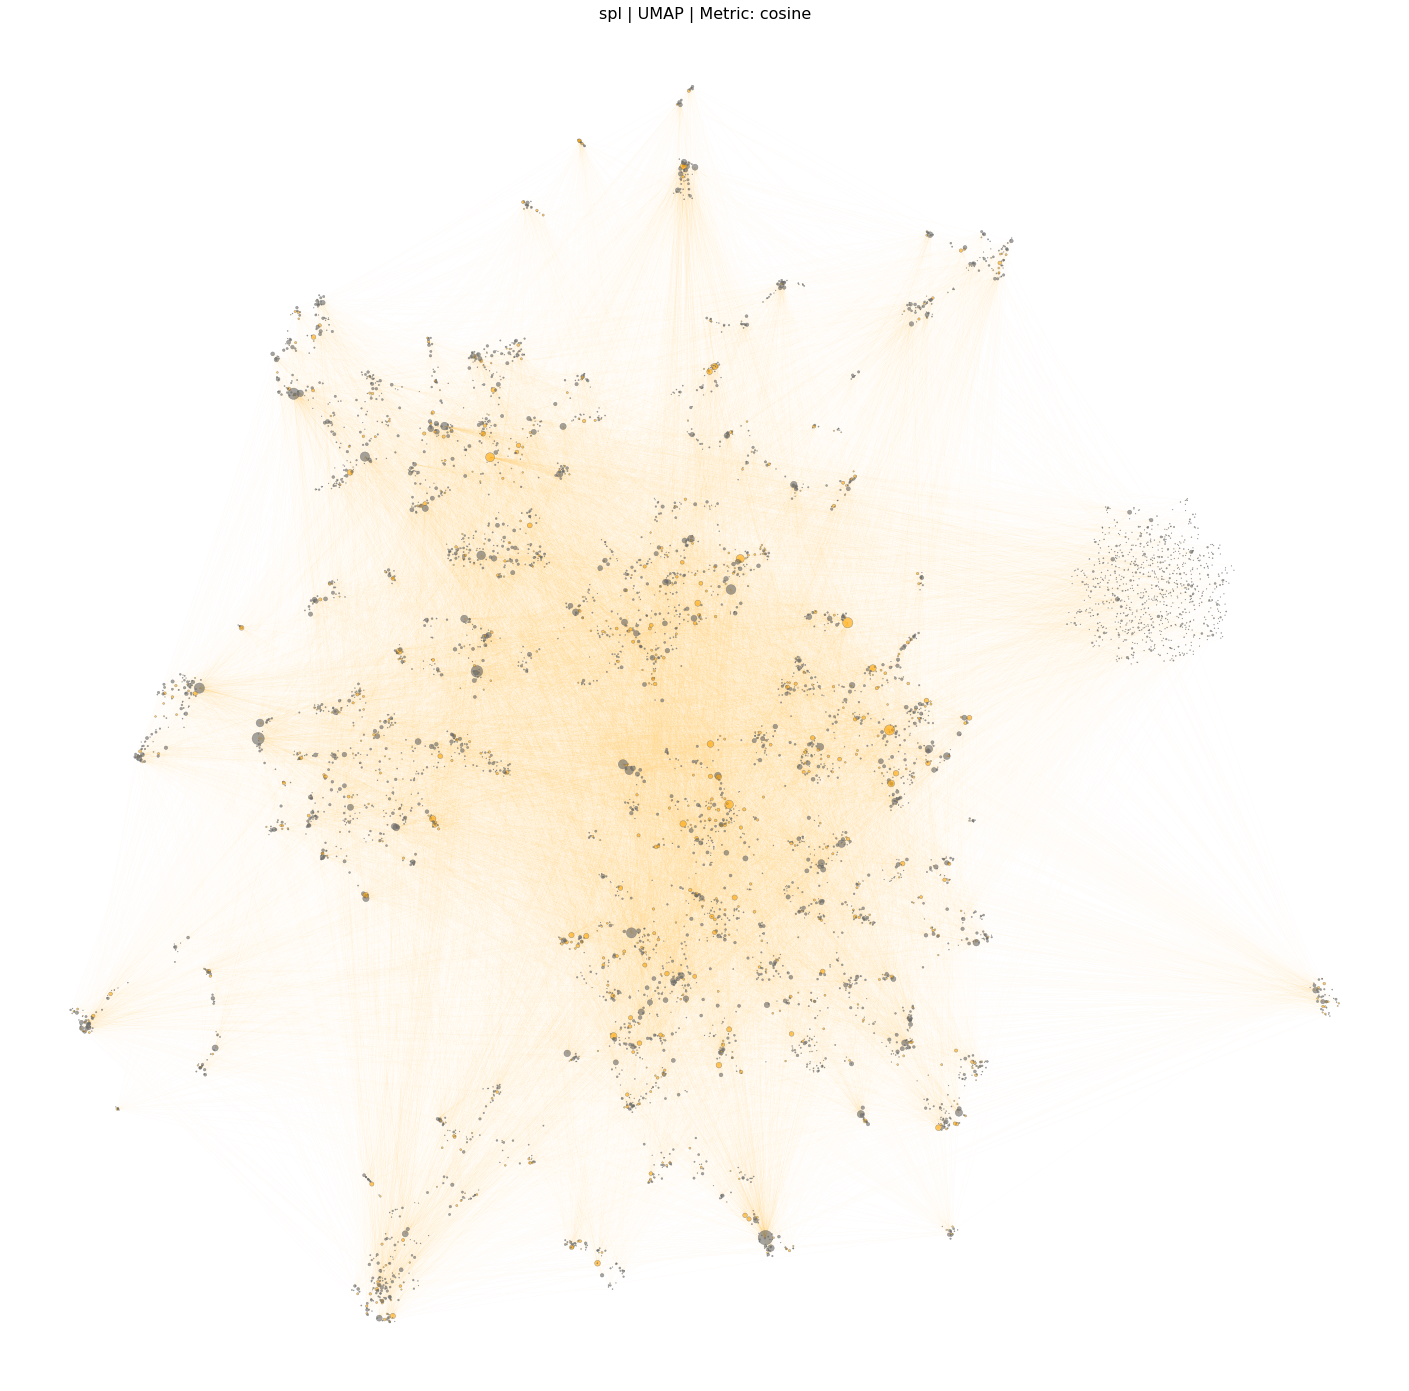

In [135]:
plt.figure(figsize=(25,25))
plt.title(feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

# ADDITIONAL

## NODE 2 VEC
+ num of walks = number of random walsk to be generated from each node in the graph
+ walk length = how many nodes are in each random walk 
+ P = return hyperparameter (probability to return to the node, the walker is coming from)
+ Q = inout hyperparameter (probability to to explore undiscovered parts of the graph)

#### EXPLANATION
+ The algorithm for the random walk generation will go over each node in the graph and will generate "number of walks" random walks, of length "walk length"


##### RESOURCES
+ https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
+ https://github.com/eliorc/Medium/blob/master/Nod2Vec-FIFA17-Example.ipynb

In [88]:
walk_lngth = 100
num_wlks = 100
wrks = 1 
dmns = 20

node2vec = Node2Vec(G, dimensions=dmns, walk_length=walk_lngth, num_walks=num_wlks, workers=wrks)

Generating walks (CPU: 1): 100%|██████████| 100/100 [40:34<00:00, 24.35s/it]  


In [89]:
%%time 

model = node2vec.fit(window=10, min_count=1)

CPU times: user 6min 46s, sys: 7.7 s, total: 6min 54s
Wall time: 6min 56s


In [90]:
%%time 
embeddings = np.array([model.wv[x] for x in G.nodes()])

CPU times: user 17 ms, sys: 8.4 ms, total: 25.4 ms
Wall time: 32.8 ms


In [91]:
%%time 
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

CPU times: user 2min 40s, sys: 2.99 s, total: 2min 42s
Wall time: 22.6 s


In [92]:
posG = dict(zip(list(G.nodes()), embeddings_2d))

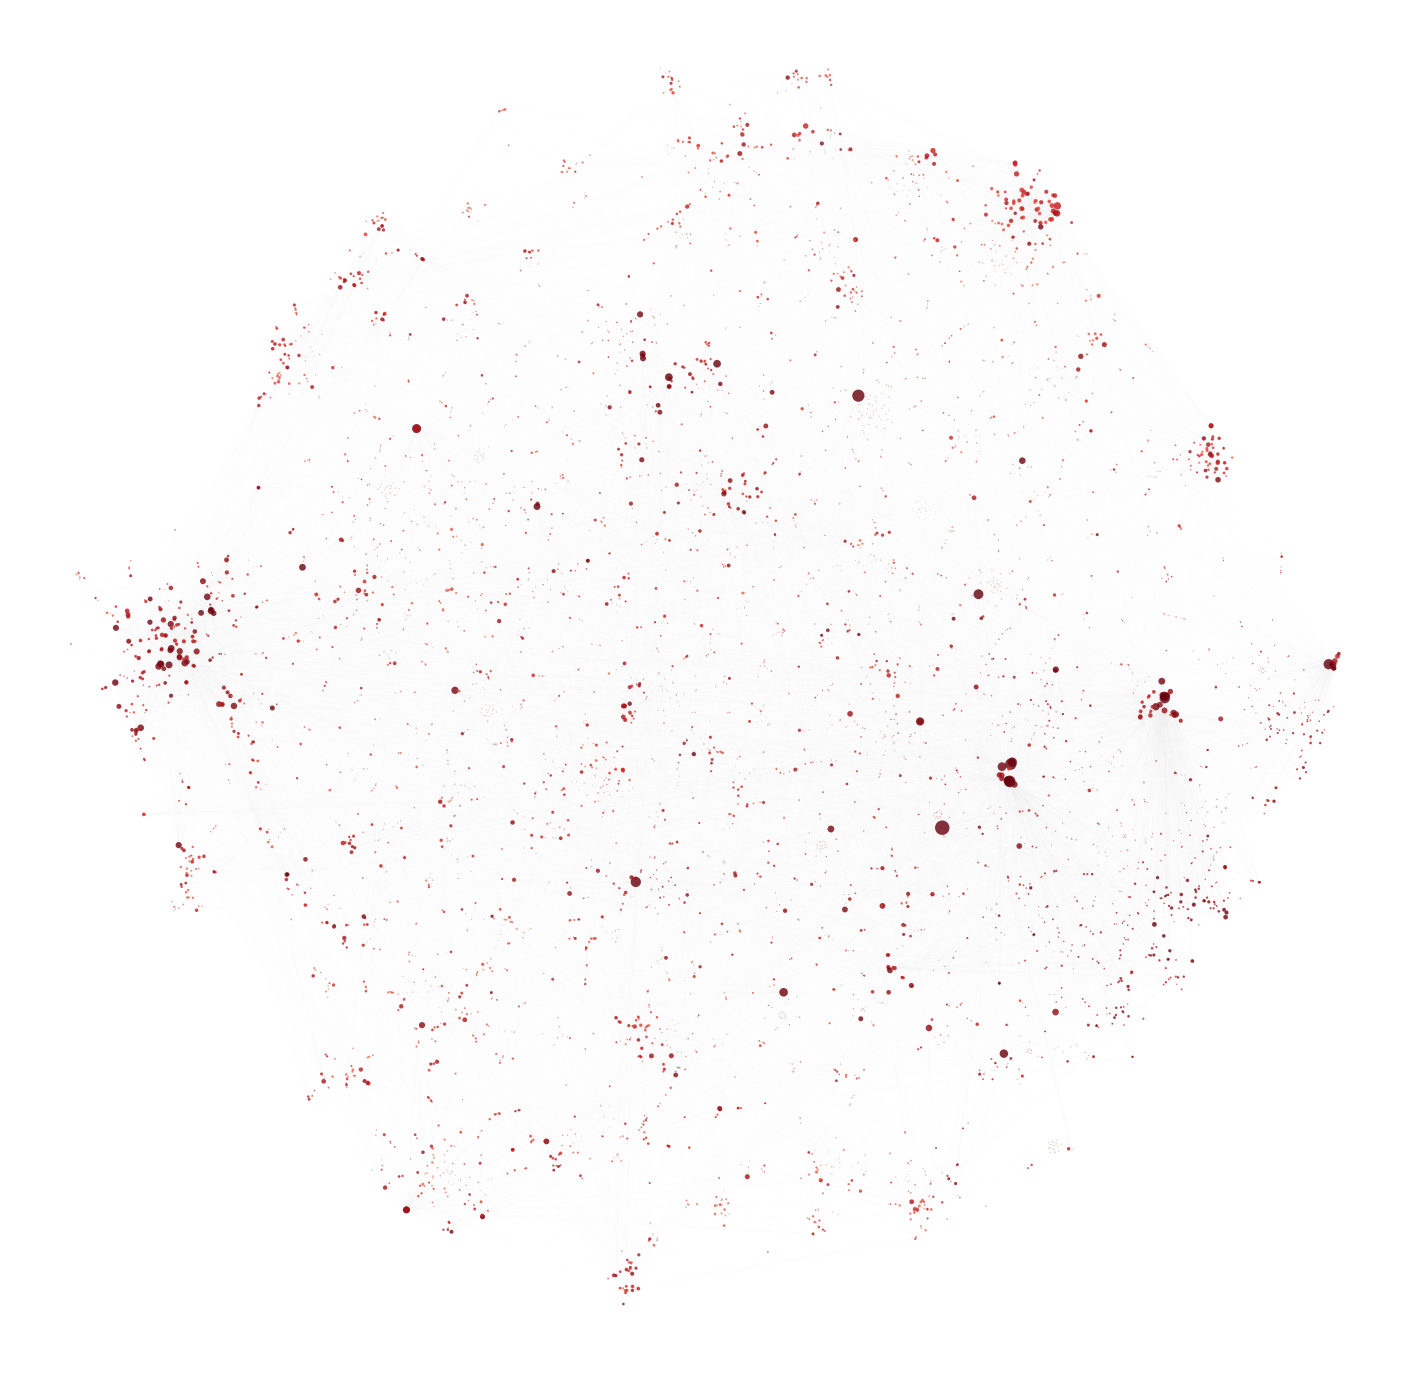

In [93]:
plt.figure(figsize=(25,25))

nx.draw_networkx_nodes(G, posG, edgecolors = node_edge_col, linewidths = 0.1, node_color = colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dnode2vec_'+'walklength'+str(walk_lngth)+'_numwalks'+str(num_wlks)+'_workers'+str(wrks)+'_dims'+str(dmns)+'_organism_nx.png')

plt.show()

____________
# 3D
____________


___
## LANDSCAPES
___

In [684]:
# ----------------------------------------------------        
# Define z-parameter
# ---------------------------------------------------- 

# Degree Centrality
#dict_z = {key:d_clos[key] for key in G.nodes()}

# Essentiality
dict_z = d_essentiality_scores_sorted
z_list = list(dict_z.values())

### tSNE

In [685]:
posG_land = {}
cc = 0
for k,v in posG_tsne.items():
    posG_land[k] = (v[0],v[1],z_list[cc])
    cc+=1
    
tsne_nodes = get_trace_nodes(posG_land, l_features, colours, size3d)
tsne_edges = get_trace_edges(G, posG_land, edge_colordark)

tsne_data = [tsne_edges, tsne_nodes]
#tsne_data = [tsne_nodes]

In [686]:
print('Perplexity:', prplxty)
print('Early Exaggeration:', density)
print('Learning rate:', l_rate)
print('Iterations:', steps)

fig = pgo.Figure()
for i in tsne_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      aspectratio=dict(
                        x=1,
                        y=1,
                        z=1
                    ),
                    camera=dict(
                        center=dict(
                            x=0,
                            y=0,
                            z=0
                        ),
                        eye=dict(
                            x=1.96903462608,
                            y=-1.09022831971,
                            z=0.405345349304
                        ),
                        up=dict(
                            x=0,
                            y=0, 
                            z=1
                        )
                    ),
                    dragmode="turntable",
                    #annotations=annotations,
                ))
    
#fig.update_layout(template='plotly_dark', height = 1000, width = 2200)
#fig.update_layout(template=None, height = 1000, width = 2200)

#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/Landscapes_tsne_'+feature+'_'+metric+'_'+organism+'.html', auto_open=True)

Perplexity: 50
Early Exaggeration: 12
Learning rate: 2000
Iterations: 800


'output_plots/Landscapes_tsne_adj_cosine_Yeast.html'

### UMAP

In [687]:
posG_land = {}
cc = 0
for k,v in posG_umap.items():
    posG_land[k] = (v[0],v[1],z_list[cc])
    cc+=1
    
umap_nodes = get_trace_nodes(posG_land, l_features, colours, size3d)
umap_edges = get_trace_edges(G, posG_land, edge_colordark)

umap_data = [umap_edges, umap_nodes]
#tsne_data = [tsne_nodes]

In [688]:
print('# Neighbors: ', n_neighbors)
print('Spread: ', spread)
print('Min. Distance: ', min_dist)
print('Metric: ', metric)


fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      aspectratio=dict(
                        x=1,
                        y=1,
                        z=1
                    ),
                    camera=dict(
                        center=dict(
                            x=0,
                            y=0,
                            z=0
                        ),
                        eye=dict(
                            x=1.96903462608,
                            y=-1.09022831971,
                            z=0.405345349304
                        ),
                        up=dict(
                            x=0,
                            y=0,
                            z=1
                        )
                    ),
                    dragmode="turntable",
                    #annotations=annotations,
                ))
    
    
#fig.update_layout(template='plotly_dark', height = 1000, width = 2200)
#fig.update_layout(template=None, height = 1000, width = 2200)

#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/Landscapes_umap_'+feature+'_'+metric+'_'+organism+'.html', auto_open=True)

# Neighbors:  5
Spread:  1.0
Min. Distance:  0.5
Metric:  cosine


'output_plots/Landscapes_umap_adj_cosine_Yeast.html'

### LANDSCAPE | EXPORT Coordinates x,y,z,rgba

In [689]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [691]:
# t-SNE 

df_xyz_landscape_tsne = pd.DataFrame(posG_tsne, index=["x","y"]).T
df_xyz_landscape_tsne["z"] = z_list

df_xyz_landscape_tsne['r'] = colours_r
df_xyz_landscape_tsne['g'] = colours_g
df_xyz_landscape_tsne['b'] = colours_b
df_xyz_landscape_tsne['a'] = colours_a

df_xyz_landscape_tsne.to_csv(r'output_csv/landscape_tsne_XYZ_RGBA_'+feature+'_'+organism+'.csv', index = True)

In [ ]:
# UMAP 

df_xyz_landscape_umap = pd.DataFrame(posG_umap, index=["x","y"]).T
df_xyz_landscape_umap["z"] = z_list

df_xyz_landscape_umap['r'] = colours_r
df_xyz_landscape_umap['g'] = colours_g
df_xyz_landscape_umap['b'] = colours_b
df_xyz_landscape_umap['a'] = colours_a

df_xyz_landscape_umap.to_csv(r'output_csv/landscape_umap_XYZ_RGBA_'+feature+_'+organism+'.csv', index = True)

____
## 3D PORTRAITS
____

In [769]:
prplxty3d = 50 # range: 5-50 / default = 30.#
density3d = 1.2 # default 12.
l_rate3d = 1000 # default 200.
steps3d = 500 #min 250

#metric = 'correlation'
metric = 'cosine'

In [770]:
tsne_3D = embed_tsne_3D(DM, prplxty3d, density3d, l_rate3d, steps3d)
posG_3D = get_posG_3D(genes, tsne_3D)

In [771]:
tsne_nodes = get_trace_nodes(posG_3D, l_features, colours, size3d)
tsne_edges = get_trace_edges(G, posG_3D, edge_colordark)

tsne_data = [tsne_edges, tsne_nodes]
#tsne_data = [tsne_nodes]

In [772]:
print('Perplexity:', prplxty3d)
print('Early Exaggeration:', density3d)
print('Learning rate:', l_rate3d)
print('Iterations:', steps3d)

fig = pgo.Figure()
for i in tsne_data:
    fig.add_trace(i)
fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      aspectratio=dict(
                        x=1,
                        y=1,
                        z=1
                    ),
                    camera=dict(
                        center=dict(
                            x=0,
                            y=0,
                            z=0
                        ),
                        eye=dict(
                            x=1.96903462608,
                            y=-1.09022831971,
                            z=0.405345349304
                        ),
                        up=dict(
                            x=0,
                            y=0,
                            z=1
                        )
                    ),
                    dragmode="turntable",
                    #annotations=annotations,
                ))
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dportrait_tsne_'+feature+'_'+metric+'_Human.html', auto_open=True)

Perplexity: 50
Early Exaggeration: 1.2
Learning rate: 1000
Iterations: 500


'output_plots/3Dportrait_tsne_centralities_cosine_Human.html'

#### UMAP

In [773]:
n_neighbors = 4 # balance between local and global structure in the data
spread = 10.
min_dist = .1 # defines how dense points are stacked together 
metric='cosine'

In [774]:
%%time 
umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)
posG_3D = get_posG_3D(genes, umap_3D)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



CPU times: user 18.6 s, sys: 1.24 s, total: 19.9 s
Wall time: 10.7 s


In [775]:
%%time 
umap_edges = get_trace_edges(G, posG_3D, edge_colordark) 
umap_nodes = get_trace_nodes(posG_3D,  l_features, colours, size3d)

umap_data = [umap_edges, umap_nodes]
#umap_data = [umap_nodes]

CPU times: user 1.02 s, sys: 44.8 ms, total: 1.06 s
Wall time: 1.07 s


In [776]:
print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)


fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      aspectratio=dict(
                        x=1,
                        y=1,
                        z=1
                    ),
                    camera=dict(
                        center=dict(
                            x=0,
                            y=0,
                            z=0
                        ),
                        eye=dict(
                            x=1.96903462608,
                            y=-1.09022831971,
                            z=0.405345349304
                        ),
                        up=dict(
                            x=0,
                            y=0,
                            z=1
                        )
                    ),
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
    
#fig.update_layout(template='plotly_dark', showlegend=False, width=2000, height=2000)
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dportrait_umap_'+feature+'_'+metric+'_'+organism+'.html', auto_open=True)

# Neighbours: 4
Spread: 10.0
Min. Distance: 0.1


'output_plots/3Dportrait_umap_centralities_cosine_Yeast.html'

#### UMAP PORTRAIT EXPORT Coordinates

In [ ]:
# EXPORT as dataframe

df_3Dportrait_umap = pd.DataFrame(umap_posG3d).T
df_3Dportrait_umap.to_csv(r'output_csv/3DPortrait_umap_'+feature+'_'+organism+'_'+'lrate_'+l_rate3d+'steps_'+steps3d+'_'+metric+'.csv', index = True)

In [ ]:
# IMPORT and convert df to dict 
df_umap_posG3d = pd.read_csv('output_csv/3DPortrait_umap_'+feature+'_'+organism+'_'+'lrate_'+l_rate3d+'steps_'+steps3d+'_'+metric+'.csv', index_col=0)
X_umap = list(df_umap_posG3d['0'])
Y_umap = list(df_umap_posG3d['1'])
Z_umap = list(df_umap_posG3d['2'])

umap_posG3d = dict(zip(list(G.nodes()),zip(X_umap,Y_umap,Z_umap)))

## SPHERE

#### UMAP

In [890]:
# ----------------------------------------------------        
# Radius parameter
# ----------------------------------------------------        

In [914]:
# Essentiality
d_param = d_essentiality_scores_sorted

In [905]:
# Closeness Centrality
d_clos_r = {}
for i,j in d_clos.items():
    d_clos_r[i] = round(j,2)
    
d_binned = bin_nodes(d_clos_r)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
d_param = {key:d_node_bin[key] for key in G.nodes()}

In [969]:
# Degree Centrality
d_degs_r = {}
for i,j in d_deghubs.items():
    d_degs_r[i] = round(j,1)
    
d_binned = bin_nodes(d_degs_r)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
d_param = {key:d_node_bin[key] for key in G.nodes()}

In [964]:
# Centrality Metrics average 
d_centr = {}
for i,j in df_centralities.iterrows():
    d_centr[i] = round((j[0]+j[1]+j[2]+j[3])/4,2)
    
d_binned = bin_nodes(d_centr)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
d_param = {key:d_node_bin[key] for key in G.nodes()}

In [970]:
len(set(d_param.values()))

9

In [966]:
%%time 
umap_sphere = embed_umap_sphere(G, DM, n_neighbors, spread, min_dist, metric)
umap_sphere_withrad = get_posG_with_sphere_radius(G, umap_sphere, d_param)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



CPU times: user 56.9 s, sys: 561 ms, total: 57.5 s
Wall time: 46.6 s


In [967]:
%%time
umap_sphere_trace_edges = get_trace_edges(G, umap_sphere_withrad, edge_colordark)
umap_sphere_trace_nodes = get_trace_umap_sphere(umap_sphere_withrad, l_features, colours, size3d)
umap_sphere_data = [umap_sphere_trace_edges, umap_sphere_trace_nodes]

CPU times: user 872 ms, sys: 18.7 ms, total: 891 ms
Wall time: 892 ms


In [968]:
print('Metric:', metric)

fig = pgo.Figure()
for i in umap_sphere_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, autosize = True,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      #aspectratio=dict(
                      #  x=1,
                      #  y=1,
                      #  z=1
                    #),
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
    
#fig.update_layout(template='plotly_dark', showlegend=False, width=2000, height=2000)
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dsphere_umap_'+feature+'_'+metric+'_'+organism+'.html', auto_open=True)

Metric: cosine


'output_plots/3Dsphere_umap_centralities_cosine_Yeast.html'

# ADDITIONAL STUFF

+ HUBS COLOURED

In [136]:
feature = 'HUBS'

df_centralities = pd.read_csv('output_csv/Features_centralities_Dataframe_Human.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(),df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

cutoff = 3 # number of considered hub nodes 
d_hub_nodes = identify_hubs(d_deghubs, d_clos, d_betw, cutoff)

colours = color_majornodes(G, d_hub_nodes)
#colours = color_nodes_from_dict(G,d_hub_nodes)
edge_color = color_majornodes_outgoingedges(G, d_hub_nodes)

# Annotations 

d_hub_coords = {}
for node,hub in d_hub_nodes.items():
    for k,v in posG.items():
        if node == str(k):
            d_hub_coords[node] = v
            
hub_x = []
hub_y = []
hub_z = []
for node,coords in d_hub_coords.items():
    hub_x.append(coords[0])
    hub_y.append(coords[1])
    hub_z.append(coords[2])
    
annotations = [dict(
                x=hub_x,
                y=hub_y,
                z=hub_z,
                showarrow=True,
                text="Hubs: "+str(i),
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                ) for i, hub_x, hub_y, hub_z in zip(range(1,len(d_hub_nodes)+1),hub_x, hub_y, hub_z)]

+ CLUSTERS COLOURED

In [73]:
feature = 'CLUS'

df_posG = pd.DataFrame(posG).T

n_clus = 15
n_iterations = 50

d_node_clusterid = get_node_clusterid(df_posG, n_clus, n_iterations)
cluster_center_x, cluster_center_y, cluster_center_z = get_clustercenter_xyz(df_posG, n_clus, n_iterations)

colours = color_nodes_from_dict(G, d_node_clusterid)

trace_centers = pgo.Scatter3d(x = cluster_center_x,
                             y = cluster_center_y,
                             z = cluster_center_z,
                                 mode = 'markers',
                                 marker=dict(
                                    size=3,
                                    color='lightgrey',
                                    opacity=1)
                                 )

annotations = [dict(
                x=xi,
                y=yi,
                z=zi,
                showarrow=True,
                text="Cluster: "+str(i),
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                ) for i, xi, yi, zi in zip(range(1,n_clus+1), cluster_center_x,cluster_center_y,cluster_center_z)]

+ CLOSENESS CENTRALITY COLOR 

In [ ]:
feature = 'CLOSE'

# Define colour parameter
d_to_be_coloured = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)


# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
palette = sns.color_palette('Reds', colour_count)

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col_clos = list(d_node_colour_sorted.values())

colours = l_col_clos 

### COLOURING SUBCATEGORIES e.g. Disease subcategory (i.e. functional property)

In [ ]:
# input = dict

n = len(sub_categories)
colors = generate_colorlist_nodes(n)

doid_coloured = {}
c=0
for k,v in sub_categories.items():
    doid_coloured[k[1]]=colors[c]
    c+=1
    
d_gene_colours = {}
for doid, gene in d_do_genes.items(): 
    for i in gene:
        for do, col in doid_coloured.items():
            if doid == do:
                d_gene_colours[i]=col

# SORT dict based on G.nodes
d_gene_colours_sorted = {key:d_gene_colours[key] for key in G.nodes()}

l_col_subcat = list(d_gene_colours_sorted.values())


# NODE COLOURING based on Subcategory
colours = l_col_subcat 
edge_color = 'lightgrey'

#sns.palplot(colours)

### COLOURING DISEASE SCORES

In [ ]:
# TO DO : MAKE FUNCTION FOR COLORING 

gene_list = gene_list_retisarc



# COLOURS GENERATED / disease score and neighboring nodes

n = len(gene_list)
color_major = generate_colorlist_nodes(n)
 
factor = 1.7 # the higher the lighter
color_minor = []
for i in color_major:
    r,g,b = hex_to_rgb(i)
    color_light = adjust_color_lightness(r,g,b,factor)
    color_minor.append(color_light)
    
    
# ------------------------------------------------------
# NODES coloured 

# Major nodes coloured
d_col_major = {}
for n in d_major_score.keys():
    for i in color_major:
        d_col_major[n] = i

d_col_minor = {}
for node,col in d_col_major.items():
    for node in d_col_major.keys():
        for nd,neigh in major_neigh.items():
            for n in neigh:
                for i in color_minor:
                    if node==nd and n not in d_col_major.keys():
                        d_col_minor[n] = i
                    
d_col = {**d_col_major,**d_col_minor}

d_grey = {}
for i in G.nodes():
    if i not in d_col.keys():
        d_grey[i] = 'lightgrey'
        
        
d_col_all = {**d_col_major, **d_col_minor, **d_grey}
d_col_all_sorted = {key:d_col_all[key] for key in G.nodes()}

l_col_all = list(d_col_all_sorted.values())

colours = l_col_all

# ------------------------------------------------------
# EDGES coloured 

edge_lst = []
for edge in G.edges():
    for e in edge:
        for node in d_col_major.keys():
            if e == node:
                edge_lst.append(edge)
                
d_col_edges = {}
for e in edge_lst:
    for node,col in d_col_major.items():
        if e[0] == node:
            d_col_edges[e]=col
        elif e[1] == node:
            d_col_edges[e]=col

d_grey_edges = {}
for edge in G.edges():
    if edge not in d_col_edges.keys(): 
        d_grey_edges[edge] = 'lightgrey'
        
d_edges_all = {**d_col_edges, **d_grey_edges}

# Sort according to G.edges()
d_edges_all_sorted = {key:d_edges_all[key] for key in G.edges()}

edge_color = list(d_edges_all_sorted.values())